In [1]:
!pip install --disable-pip-version-check -q sagemaker==2.35.0

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


In [3]:
import boto3
import botocore 
import sagemaker 
import numpy as np 
import pandas as pd 
config = botocore.config.Config(user_agent_extra="dlai-pds/c1/w2")
sm = boto3.client(service_name='sagemaker',config=config)
sess = sagemaker.Session(sagemaker_client=sm)
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = sess.boto_region_name 

In [4]:
import matplotlib.pyplot as plt

In [5]:
!aws s3 cp 's3://dlai-practical-data-science/data/transformed/womens_clothing_ecommerce_reviews_transformed.csv' ./

download: s3://dlai-practical-data-science/data/transformed/womens_clothing_ecommerce_reviews_transformed.csv to ./womens_clothing_ecommerce_reviews_transformed.csv


In [6]:
path = './womens_clothing_ecommerce_reviews_transformed.csv'
df = pd.read_csv(path)
df.head()

,sentiment,review_body,product_category
0,1,If this product was in petite i would get the...,Blouses
1,1,Love this dress! it's sooo pretty. i happene...,Dresses
2,0,I had such high hopes for this dress and reall...,Dresses
3,1,I love love love this jumpsuit. it's fun fl...,Pants
4,1,This shirt is very flattering to all due to th...,Blouses


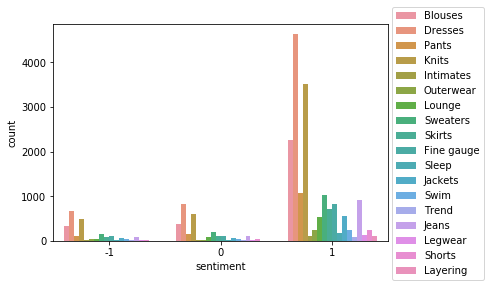

In [8]:
import seaborn as sns
sns.countplot(data=df, x='sentiment', hue='product_category')
plt.legend(loc='upper right',bbox_to_anchor=(1.3, 1.1))

In [9]:
data_s3_uri_unbalanced = sess.upload_data(bucket=bucket,key_prefix='bias/unbalanced', 
                               path='./womens_clothing_ecommerce_reviews_transformed.csv')
data_s3_uri_unbalanced 

's3://sagemaker-us-east-1-050272463904/bias/unbalanced/womens_clothing_ecommerce_reviews_transformed.csv'

In [ ]:
'''
s3_data_input_path=..., # S3 object path containing the unbalanced dataset
s3_output_path=..., # path to store the output
label='...', # target column
'''

In [10]:
from sagemaker import clarify 
bias_report_unbalanced_output_path = 's3://{}/bias/generated_bias_report/unbalanced'.format(bucket)
data_config_unbalanced = clarify.DataConfig(
s3_data_input_path=data_s3_uri_unbalanced,
s3_output_path=bias_report_unbalanced_output_path,
label='sentiment',
headers=df.columns.to_list(),
dataset_type='text/csv'
)

In [11]:
bias_config_unbalanced = clarify.BiasConfig(label_values_or_threshold=[1],
                                           facet_name="product_category")

In [12]:
clarify_processor_unbalanced = clarify.SageMakerClarifyProcessor(role=role,
                                                                instance_count=1,
                                                                instance_type='ml.m5.large',
                                                                sagemaker_session=sess)

In [ ]:
'''
wait=False, # whether the call should wait until the job completes (default: True)
logs=False # whether to show the logs produced by the job. Only meaningful when wait is True (default: True)
'''

In [14]:
clarify_processor_unbalanced.run_pre_training_bias(
data_config = data_config_unbalanced,
data_bias_config = bias_config_unbalanced,
methods=["CI", "DPL", "KL", "JS", "LP", "TVD", "KS"],
wait=False,
logs=False
)


Job Name:  Clarify-Pretraining-Bias-2021-09-04-12-35-23-259
Inputs:  [{'InputName': 'dataset', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-050272463904/bias/unbalanced/womens_clothing_ecommerce_reviews_transformed.csv', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'analysis_config', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-050272463904/bias/generated_bias_report/unbalanced/analysis_config.json', 'LocalPath': '/opt/ml/processing/input/config', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'analysis_result', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sagemaker-us-east-1-050272463904/bias/generated_bias_report/unbalanced', 'LocalPath': '/opt/ml/processing/output', 'S3UploadMode': 'EndOfJob'}

In [15]:
run_unbalanced_bias_processing_job_name = clarify_processor_unbalanced.latest_job.job_name
print(run_unbalanced_bias_processing_job_name)

Clarify-Pretraining-Bias-2021-09-04-12-35-23-259


In [16]:
from IPython.core.display import display, HTML
display(HTML('<b>Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/processing-jobs/{}">processing job</a></b>'.format(region, run_unbalanced_bias_processing_job_name)))

In [17]:
from IPython.core.display import display, HTML
display(HTML('<b>Review <a target="blank" href="https://console.aws.amazon.com/cloudwatch/home?region={}#logStream:group=/aws/sagemaker/ProcessingJobs;prefix={};streamFilter=typeLogStreamPrefix">CloudWatch logs</a> after about 5 minutes</b>'.format(region, run_unbalanced_bias_processing_job_name)))

In [18]:
running_processor = sagemaker.processing.ProcessingJob.from_processing_name(processing_job_name=run_unbalanced_bias_processing_job_name,
                                                                           sagemaker_session=sess)

In [19]:
%%time
running_processor.wait(logs=False)

!CPU times: user 18.2 ms, sys: 204 µs, total: 18.4 ms
Wall time: 70.6 ms


In [21]:
!aws s3 ls $bias_report_unbalanced_output_path/

2021-09-04 12:40:53      31732 analysis.json
2021-09-04 12:35:24        346 analysis_config.json
2021-09-04 12:40:53     385665 report.html
2021-09-04 12:40:53     121999 report.ipynb
2021-09-04 12:40:53     139371 report.pdf


In [23]:
!aws s3 cp --recursive $bias_report_unbalanced_output_path ./generated_bias_report/unbalanced/

download: s3://sagemaker-us-east-1-050272463904/bias/generated_bias_report/unbalanced/analysis_config.json to generated_bias_report/unbalanced/analysis_config.json
download: s3://sagemaker-us-east-1-050272463904/bias/generated_bias_report/unbalanced/analysis.json to generated_bias_report/unbalanced/analysis.json
download: s3://sagemaker-us-east-1-050272463904/bias/generated_bias_report/unbalanced/report.ipynb to generated_bias_report/unbalanced/report.ipynb
download: s3://sagemaker-us-east-1-050272463904/bias/generated_bias_report/unbalanced/report.pdf to generated_bias_report/unbalanced/report.pdf
download: s3://sagemaker-us-east-1-050272463904/bias/generated_bias_report/unbalanced/report.html to generated_bias_report/unbalanced/report.html


In [25]:
from IPython.core.display import display, HTML
display(HTML('<b>Review <a target="blank" href="./generated_bias_report/unbalanced/report.html">unbalanced bias report</a></b>'))

In [26]:
df_grouped_by = df.groupby(['product_category', 'sentiment'])
df_balanced = df_grouped_by.apply(lambda x: x.sample(df_grouped_by.size().min()).reset_index(drop=True))

In [27]:
df_balanced

sentiment  \
product_category sentiment                
Blouses          -1        0         -1   
                           1         -1   
                           2         -1   
                           3         -1   
                           4         -1   
...                                 ...   
Trend             1        4          1   
                           5          1   
                           6          1   
                           7          1   
                           8          1   

                                                                    review_body  \
product_category sentiment                                                        
Blouses          -1        0  Poor quality. i expected much more from the ma...   
                           1  Material was a tad rough for my liking. the co...   
                           2  Loved this shirt when i saw the picture. unfor...   
                           3  Unfortunately this one is going back. the fit ...   
                           4  The shirt is absolutely cute looking. but that...   
...                                                                         ...   
Trend             1        4  You just can't go wrong with a perfect white t...   
                           5  This lovely skirt absolutely hits the mark for...   
                           6  This dress runs tts. the fabric is a good qual...   
                           7  I love this coat! it does run a bit large. i a...   
                           8  Dress is beautiful in person  light material t...   

                             product_category  
product_category sentiment                     
Blouses          -1        0          Blouses  
                           1          Blouses  
                           2          Blouses  
                           3          Blouses  
                           4          Blouses  
...                                       ...  
Trend             1        4            Trend  
                           5            Trend  
                           6            Trend  
                           7            Trend  
                           8            Trend  

[486 rows x 3 columns]

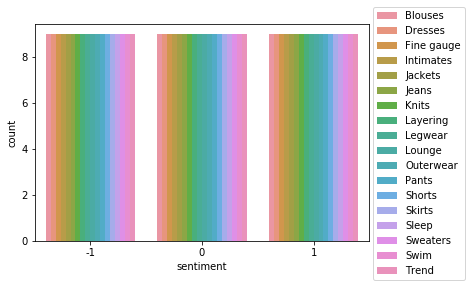

In [28]:
import seaborn as sns
sns.countplot(data=df_balanced, x='sentiment', hue='product_category')
plt.legend(loc='upper right',bbox_to_anchor=(1.3, 1.1))

In [29]:
path_balanced = './womens_clothing_ecommerce_reviews_balanced.csv'
df_balanced.to_csv(path_balanced, index=False, header=True)
data_s3_uri_balanced = sess.upload_data(bucket=bucket, key_prefix='bias/balanced', path=path_balanced)
data_s3_uri_balanced

's3://sagemaker-us-east-1-050272463904/bias/balanced/womens_clothing_ecommerce_reviews_balanced.csv'

In [30]:
from sagemaker import clarify
bias_report_balanced_output_path = 's3://{}/bias/generated_bias_report/balanced'.format(bucket)
data_config_balanced = clarify.DataConfig(
    s3_data_input_path=data_s3_uri_balanced, 
    s3_output_path=bias_report_balanced_output_path, 
    label='sentiment', 
    headers=df_balanced.columns.to_list(),
    dataset_type='text/csv'
)

In [31]:
bias_config_balanced = clarify.BiasConfig(
    label_values_or_threshold=[1],
    facet_name='product_category' 
)

In [32]:
clarify_processor_balanced = clarify.SageMakerClarifyProcessor(role=role,
                                                      instance_count=1,
                                                      instance_type='ml.m5.large',
                                                      sagemaker_session=sess)

In [33]:
clarify_processor_balanced.run_pre_training_bias(
    data_config=data_config_balanced, 
    data_bias_config=bias_config_balanced, 
    methods=["CI", "DPL", "KL", "JS", "LP", "TVD", "KS"],
    wait=False,
    logs=False
)


Job Name:  Clarify-Pretraining-Bias-2021-09-04-13-34-52-819
Inputs:  [{'InputName': 'dataset', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-050272463904/bias/balanced/womens_clothing_ecommerce_reviews_balanced.csv', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'analysis_config', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-050272463904/bias/generated_bias_report/balanced/analysis_config.json', 'LocalPath': '/opt/ml/processing/input/config', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'analysis_result', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sagemaker-us-east-1-050272463904/bias/generated_bias_report/balanced', 'LocalPath': '/opt/ml/processing/output', 'S3UploadMode': 'EndOfJob'}}]


In [34]:
run_balanced_bias_processing_job_name = clarify_processor_balanced.latest_job.job_name
print(run_balanced_bias_processing_job_name)

Clarify-Pretraining-Bias-2021-09-04-13-34-52-819


In [35]:
from IPython.core.display import display, HTML
display(HTML('<b>Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/processing-jobs/{}">processing job</a></b>'.format(region, run_balanced_bias_processing_job_name)))

In [ ]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="blank" href="https://console.aws.amazon.com/cloudwatch/home?region={}#logStream:group=/aws/sagemaker/ProcessingJobs;prefix={};streamFilter=typeLogStreamPrefix">CloudWatch logs</a> after about 5 minutes</b>'.format(region, run_balanced_bias_processing_job_name)))

In [36]:
running_processor = sagemaker.processing.ProcessingJob.from_processing_name(processing_job_name=run_balanced_bias_processing_job_name,
                                                                            sagemaker_session=sess)

In [37]:
%%time
running_processor.wait(logs=False)

...........................................!CPU times: user 167 ms, sys: 27.4 ms, total: 194 ms
Wall time: 3min 36s


In [38]:
!aws s3 cp --recursive $bias_report_balanced_output_path ./generated_bias_report/balanced/

download: s3://sagemaker-us-east-1-050272463904/bias/generated_bias_report/balanced/analysis_config.json to generated_bias_report/balanced/analysis_config.json
download: s3://sagemaker-us-east-1-050272463904/bias/generated_bias_report/balanced/analysis.json to generated_bias_report/balanced/analysis.json
download: s3://sagemaker-us-east-1-050272463904/bias/generated_bias_report/balanced/report.pdf to generated_bias_report/balanced/report.pdf
download: s3://sagemaker-us-east-1-050272463904/bias/generated_bias_report/balanced/report.ipynb to generated_bias_report/balanced/report.ipynb
download: s3://sagemaker-us-east-1-050272463904/bias/generated_bias_report/balanced/report.html to generated_bias_report/balanced/report.html


In [39]:
!aws s3 cp --recursive $bias_report_balanced_output_path ./generated_bias_report/balanced/

download: s3://sagemaker-us-east-1-050272463904/bias/generated_bias_report/balanced/analysis_config.json to generated_bias_report/balanced/analysis_config.json
download: s3://sagemaker-us-east-1-050272463904/bias/generated_bias_report/balanced/analysis.json to generated_bias_report/balanced/analysis.json
download: s3://sagemaker-us-east-1-050272463904/bias/generated_bias_report/balanced/report.html to generated_bias_report/balanced/report.html
download: s3://sagemaker-us-east-1-050272463904/bias/generated_bias_report/balanced/report.ipynb to generated_bias_report/balanced/report.ipynb
download: s3://sagemaker-us-east-1-050272463904/bias/generated_bias_report/balanced/report.pdf to generated_bias_report/balanced/report.pdf
